In [1]:
#Imports
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn.input_data import NiftiLabelsMasker

/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [3]:
# --- Path to input / output data ---

""" Define hrf model used for the first analysis
    Options : 
    ---------
    spm
    glover
"""
hrf_function = 'glover'
#hrf_function = 'spm'
#hrf_function = 'rat_hrf_gamma_diff'
#hrf_function = 'rat_hrf_delay_disp'


if hrf_function == 'glover':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/glover/'
elif hrf_function == 'spm':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/spm/'
elif hrf_function == 'rat_hrf_gamma_diff':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_gamma_diff/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_gamma_diff/'
elif hrf_function == 'rat_hrf_delay_disp':
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_delay_disp/'
    output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/rat_hrf_delay_disp/'
    
else:
    print('No file to be saved. Check that hrf_function is well defined.')



In [4]:
# Output directories 

mask_rois_dir = os.path.join(output_dir, 'mask_ROIs/')
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
effect_size_dir = os.path.join(output_dir, 'mask_ROIs/effect_size/')
effect_variance_dir = os.path.join(output_dir, 'mask_ROIs/effect_variance/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')
predicted_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/predicted_timeseries/')


if not os.path.exists(mask_rois_dir):
    os.makedirs(mask_rois_dir)
if not os.path.exists(zscores_dir):
    os.makedirs(zscores_dir)
if not os.path.exists(real_timeseries_dir):
    os.makedirs(real_timeseries_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)  
if not os.path.exists(effect_size_dir):
    os.makedirs(effect_size_dir)
if not os.path.exists(effect_variance_dir):
    os.makedirs(effect_variance_dir)
if not os.path.exists(predicted_timeseries_dir):
    os.makedirs(predicted_timeseries_dir)

In [17]:
# - Init Variables 

    # Load atlas 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'

template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

    # Subject info 
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

In [32]:
# -- Extract 1 or 2 ROI per scan --

for scan in range(133, 134) :         
     
    subj_num=str(df.iloc[scan]['rat.sub'])[:-2]
    print('index:', scan)
    print('subj:', subj_num)
    
    subj_img_glob = glob.glob("/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    subj_img = nib.load(subj_img_glob)
    
    # - Load result from GLM analysis -   
    zscores_file = nib.load(first_level_output +'z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))
    residuals_file = nib.load(first_level_output +'residuals/residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))
    beta_estimates_file = nib.load(first_level_output + 'beta_estimates/beta_sub-0{}_ses-1.nii.gz'.format(subj_num))
    effect_var_file = nib.load(first_level_output + 'effect_var/effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))
    predicted_timeseries_file = nib.load(first_level_output +'predicted_timeseries/predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))
  

    #Find index of the ROI based on labels (specified in metadata)
    
    # Creates a dictionary with the atlas_label as the key and the label index as the value
    labels_dict = {row[-1].strip('"'): int(row[0]) for row in label_info}
    
    labels = ['roi_right','roi_left']  # Define which internal labels we are interested into
    label_indices = []
    
    for label in labels:
        atlas_label = df.iloc[scan][label]
        print(atlas_label)
        label_indices.append(labels_dict.get(atlas_label))  # Appends the atlas_label index to the array to search for it later

    #Extract data from ROI

    from nilearn.maskers import NiftiMasker
    roi_mask = np.isin(nilearn.image.get_data(atlas_img), label_indices)
    #roi_mask = np.logical_or(nilearn.image.get_data(atlas_img) == label_idx_1, nilearn.image.get_data(atlas_img) == label_idx_2)    # select ROIa based on the index
    
    roi_mask = roi_mask.astype(bool)

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)                       # create an mask image out of the roi selected
    masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img) 
    masker_stand = NiftiMasker(mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)

    #z_scores = masker.fit_transform(zscores_file)
    #print("Done z_scores")
    #effect_size = masker.fit_transform(beta_estimates_file)
    #print("Done effect_size")
    #effect_var = masker.fit_transform(effect_var_file)
    #print("Done effect_var")
    #predicted_timeseries = masker.fit_transform(predicted_timeseries_file)
    #print("Done predicted_timeseries")
    
    residuals = masker.fit_transform(residuals_file)
    print("Done residuals")
    real_timeseries = masker.fit_transform(subj_img)
    print("Done real_timeseries")
    
    report = masker.generate_report()
    report

    #savetxt(zscores_dir+'zscores_sub-0{}_ses-1.csv'.format(subj_num), z_scores, delimiter=',')     
    #savetxt(effect_size_dir+'effect_size_sub-0{}_ses-1.csv'.format(subj_num), effect_size, delimiter=',')    
    #savetxt(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num), effect_var, delimiter=',')    
    #savetxt(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')    
    
    savetxt(residuals_dir+'residuals_sub-0{}_ses-1.csv'.format(subj_num), residuals, delimiter=',') 
    savetxt(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',') 
    
    print("Done Saving")

index: 133
subj: 201600
Primary Visual Cortex-R
Primary Visual Cortex-L
Done residuals


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/image/resampling.py:453: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn("The provided image has no sform in its header. "


Done real_timeseries


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:365: UserWarning: No image provided to fit in NiftiMasker. Setting image to mask for reporting.
  warnings.warn(msg)


Done Saving


In [9]:
print(residuals)

[[ 4.20734179e+05  1.62304418e+05  1.45995285e+05 ... -5.04220660e+05
  -4.11827946e+05 -5.22973816e+05]
 [ 1.70253458e+05  4.71979606e+05  1.08178137e+06 ...  4.04146211e+06
   2.81846979e+06  4.01751862e+06]
 [-4.52433817e+04  4.44743460e+05  7.09890306e+05 ...  3.25074103e+06
   2.63251587e+06  3.49467436e+06]
 ...
 [ 6.47789800e+04  4.30526990e+05  8.65618019e+05 ...  2.96760730e+06
   2.44581729e+06  2.99522553e+06]
 [-4.16560626e+05 -3.83138718e+04  2.31808325e+05 ...  3.07145088e+06
   2.28502972e+06  3.02270673e+06]
 [-8.13716836e+03 -2.62272499e+03  9.72990355e+05 ...  3.87470169e+06
   2.68184611e+06  3.82142406e+06]]


In [31]:
#print(zscores)
#print("Source")
#print(subj_img)
#print(real_timeseries)
#print("Predicted")
#print(predicted_timeseries_source_file)
#print(predicted_timeseries)
pd.read_csv(real_timeseries_dir + "real_timeseries_sub-0200100_ses-1.csv")

,1.608819610520187579e+07,1.300205236584565230e+07,2.210331035397886112e+07,1.677289603748815693e+07,2.153476800000000745e+07,2.056168693462795392e+07,2.207573573795589060e+07,1.924869800000001118e+07,1.833856181976950914e+07,2.064569364215373620e+07,...,2.076687667700010166e+07,2.169073067494184896e+07,1.877026086822537333e+07,2.238073941696362942e+07,2.054721567639646679e+07,2.220437475654334947e+07,2.386884847372506931e+07,2.147120765239138529e+07,2.444659054744833708e+07,2.386629647279528528e+07
0,1.626954e+07,1.309584e+07,2.087740e+07,1.530457e+07,20456222.0,1.965297e+07,2.177251e+07,18516020.0,1.870112e+07,2.085201e+07,...,2.124868e+07,2.248747e+07,1.944809e+07,2.315570e+07,2.155394e+07,2.317534e+07,2.407840e+07,2.264363e+07,2.483603e+07,2.482695e+07
1,1.652628e+07,1.302661e+07,2.092521e+07,1.565319e+07,20482052.0,1.963548e+07,2.168263e+07,18433672.0,1.854019e+07,2.082950e+07,...,2.059259e+07,2.169314e+07,1.876832e+07,2.248056e+07,2.072002e+07,2.245566e+07,2.381951e+07,2.190936e+07,2.456903e+07,2.427412e+07
2,1.583330e+07,1.271554e+07,2.078800e+07,1.560622e+07,20303318.0,1.943685e+07,2.115637e+07,18240032.0,1.800607e+07,2.010522e+07,...,2.056718e+07,2.195678e+07,1.876965e+07,2.298460e+07,2.104960e+07,2.304914e+07,2.431812e+07,2.253982e+07,2.508905e+07,2.495854e+07
3,1.647717e+07,1.300251e+07,2.216099e+07,1.655111e+07,21647508.0,2.067597e+07,2.243013e+07,19314202.0,1.903010e+07,2.121338e+07,...,2.006164e+07,2.155050e+07,1.821984e+07,2.277268e+07,2.070077e+07,2.295008e+07,2.443768e+07,2.258243e+07,2.536947e+07,2.529224e+07
4,1.620518e+07,1.304688e+07,2.233567e+07,1.689442e+07,21855770.0,2.093292e+07,2.241644e+07,19623730.0,1.841236e+07,2.086492e+07,...,2.101791e+07,2.210150e+07,1.907493e+07,2.279435e+07,2.091145e+07,2.253948e+07,2.434978e+07,2.174189e+07,2.501075e+07,2.421248e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.523240e+07,1.236978e+07,2.067303e+07,1.471131e+07,19904110.0,1.882993e+07,2.114671e+07,17541606.0,1.884925e+07,2.050001e+07,...,2.098618e+07,2.237782e+07,1.913890e+07,2.340024e+07,2.145092e+07,2.334777e+07,2.470007e+07,2.277688e+07,2.525465e+07,2.486603e+07
145,1.542799e+07,1.244425e+07,2.148966e+07,1.580346e+07,20771918.0,1.968607e+07,2.158176e+07,18321958.0,1.859230e+07,2.050412e+07,...,2.115072e+07,2.164034e+07,1.922121e+07,2.234102e+07,2.070304e+07,2.246424e+07,2.482013e+07,2.209383e+07,2.562750e+07,2.481610e+07
146,1.602173e+07,1.284883e+07,2.140782e+07,1.570405e+07,20706978.0,1.962138e+07,2.169668e+07,18226332.0,1.867132e+07,2.082615e+07,...,2.064091e+07,2.177186e+07,1.880090e+07,2.262166e+07,2.083832e+07,2.255576e+07,2.411193e+07,2.205573e+07,2.472123e+07,2.413241e+07
147,1.490276e+07,1.231445e+07,2.151761e+07,1.630721e+07,20810270.0,1.972971e+07,2.109902e+07,18363626.0,1.798250e+07,1.972725e+07,...,2.085404e+07,2.191291e+07,1.896416e+07,2.259298e+07,2.084662e+07,2.239661e+07,2.402521e+07,2.169122e+07,2.452694e+07,2.382002e+07


TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
NiftiMasker(mask_i...

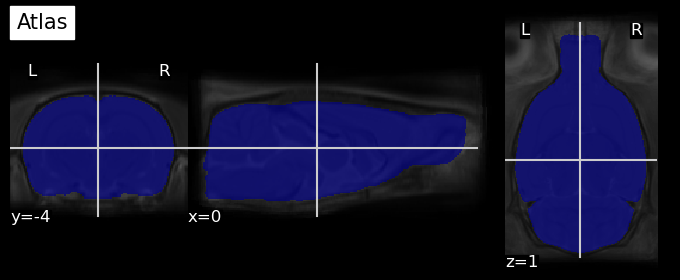

In [26]:
from nilearn import plotting

plotting.plot_roi(atlas_mask, bg_img=template_path, title="Atlas")
plotting.plot_roi(masker, bg_img=template_path, title='Masked ROIs on Rat Brain') 

#report = masker.generate_report()
#report

In [99]:
# - Extract signal based on SIGMA atlas - 
# Won't use it -> I can't deal with output T.T
# Quite long to run

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subj_img = glob.glob("/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    
    
     # - Load result from GLM analysis - 
        
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level'
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))
    residuals = nib.load(first_level_output +'/residuals/residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))
    beta_estimates = nib.load(first_level_output + '/beta_estimates/beta_sub-0{}_ses-1.nii.gz'.format(subj_num))
    effect_var = nib.load(first_level_output + '/effect_var/effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))
    predicted_timeseries = nib.load(first_level_output +'/predicted_timeseries/predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))

    
    # - Extract signal from regions - 

    masker_stand = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)
    masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, resampling_target='labels').fit(subj_img)

    z_scores = masker.fit_transform(zscores)
    print("Done z_scores")
    residuals = masker.fit_transform(residuals)
    print("Done residuals")
    effect_size = masker.fit_transform(beta_estimates)
    print("Done effect_size")
    effect_var = masker.fit_transform(effect_var)
    print("Done effect_var")
    real_timeseries = masker_stand.fit_transform(subj_img)
    print("Done real_timeseries")
    predicted_timeseries = masker.fit_transform(predicted_timeseries)
    print("Done predicted_timeseries")
    
         # Save as .csv file
    savetxt(mask_zscores_dir+'zscores_sub-0{}_ses-1.csv'.format(subj_num), z_scores, delimiter=',')     
    savetxt(residuals_dir+'residuals_sub-0{}_ses-1.csv'.format(subj_num), residuals, delimiter=',')     
    savetxt(effect_size_dir+'effect_size_sub-0{}_ses-1.csv'.format(subj_num), effect_size, delimiter=',')    
    savetxt(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num), effect_var, delimiter=',')    
    savetxt(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',') 
    savetxt(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')    



index: 0
subj: 200100
Done z_scores


KeyboardInterrupt: 